# Heart Disease Classification - Mid-Module Assessment

**Student Name:** Antony O'Neill

**Student Number:** 2418521

**Module:** CSO7008 - Artificial Intelligence

**University:** St Mary's University, Twickenham

**Date:** November 2024

---

## Overview
Binary classification to predict heart disease risk using the UCI Heart dataset.
- **Target:** output (0 = low risk, 1 = high risk)
- **Models:** Random Forest, SVM, Neural Network

---
## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

---
## 2. Load and Explore Dataset

In [429]:
dataset = pd.read_csv("heart.csv")
print(f"Shape: {dataset.shape} | Missing values: {dataset.isnull().sum().sum()}")
dataset.head()

Shape: (303, 14) | Missing values: 0


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Feature Key

| Column | Description | Data Type | Values |
|--------|-------------|-----------|--------|
| age | Age in years | Integer | 29-77 |
| sex | Biological sex | Integer | 0=Female, 1=Male |
| cp | Chest pain type | Integer | 0=Typical angina, 1=Atypical angina, 2=Non-anginal, 3=Asymptomatic |
| trtbps | Resting blood pressure (mm Hg) | Integer | 94-200 |
| chol | Serum cholesterol (mg/dl) | Integer | 126-564 |
| fbs | Fasting blood sugar > 120 mg/dl | Integer | 0=False, 1=True |
| restecg | Resting ECG results | Integer | 0=Normal, 1=ST-T abnormality, 2=LV hypertrophy |
| thalachh | Maximum heart rate achieved | Integer | 71-202 |
| exng | Exercise induced angina | Integer | 0=No, 1=Yes |
| oldpeak | ST depression induced by exercise | Float | 0.0-6.2 |
| slp | Slope of peak exercise ST segment | Integer | 0=Downsloping, 1=Flat, 2=Upsloping |
| caa | Number of major vessels coloured by fluoroscopy | Integer | 0-4 |
| thall | Thalassemia | Integer | 0=Null, 1=Fixed defect, 2=Normal, 3=Reversible defect |
| output | Target variable | Integer | 0=Low risk, 1=High risk |

In [430]:
dataset.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


---
## 3. Data Visualization

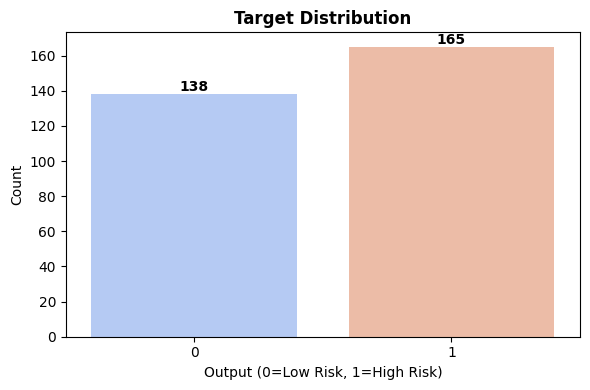

In [431]:
# Target distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='output', data=dataset, palette='coolwarm')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontweight='bold')
plt.title('Target Distribution', fontweight='bold')
plt.xlabel('Output (0=Low Risk, 1=High Risk)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

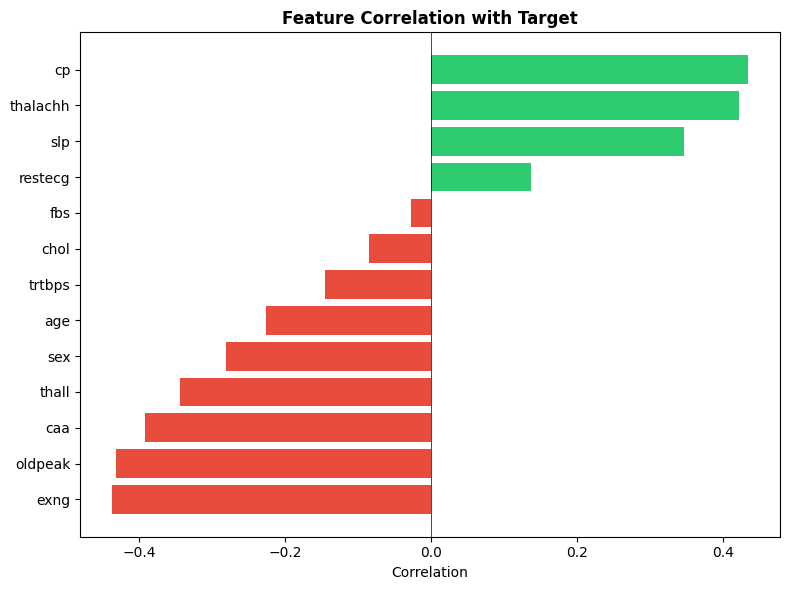

In [432]:
# Feature correlations with target
correlations = dataset.corr()['output'].drop('output').sort_values()

plt.figure(figsize=(8, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in correlations]
plt.barh(correlations.index, correlations.values, color=colors)
plt.title('Feature Correlation with Target', fontweight='bold')
plt.xlabel('Correlation')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

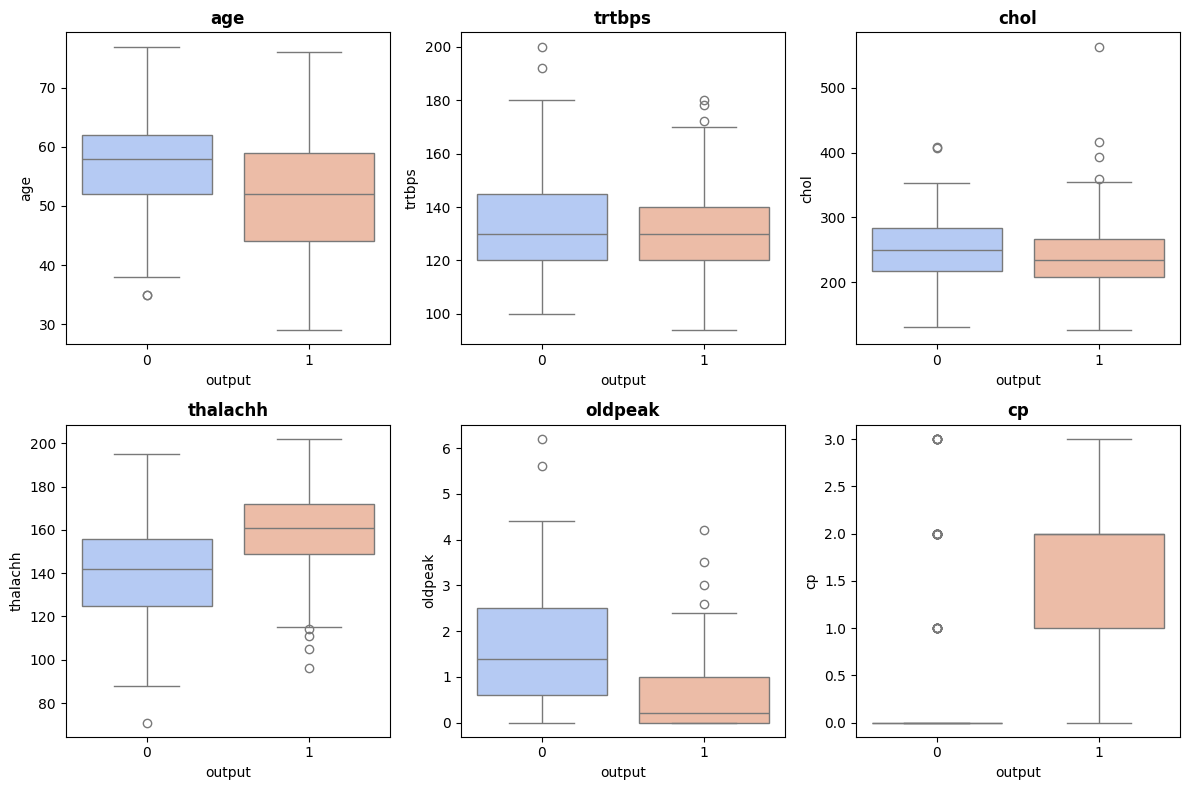

In [433]:
# Feature distributions by target
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for idx, feature in enumerate(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'cp']):
    row, col = idx // 3, idx % 3
    sns.boxplot(x='output', y=feature, data=dataset, palette='coolwarm', ax=axes[row, col])
    axes[row, col].set_title(feature, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Data Preprocessing

In [434]:
X = dataset.drop('output', axis=1)
Y = dataset['output']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]} | Testing: {X_test.shape[0]}")

Training: 242 | Testing: 61


---
## 5. Random Forest Classifier

In [435]:
# Config 1: Default
rf_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_1.fit(X_train_scaled, y_train)
rf_pred_1 = rf_model_1.predict(X_test_scaled)
rf_accuracy_1 = accuracy_score(y_test, rf_pred_1)

print(f"Config 1 - Default: {rf_accuracy_1*100:.2f}%")
print(classification_report(y_test, rf_pred_1))

Config 1 - Default: 83.61%
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



In [436]:
# Config 2: More trees, limited depth
rf_model_2 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model_2.fit(X_train_scaled, y_train)
rf_pred_2 = rf_model_2.predict(X_test_scaled)
rf_accuracy_2 = accuracy_score(y_test, rf_pred_2)

print(f"Config 2 - 200 trees, depth=10: {rf_accuracy_2*100:.2f}%")
print(classification_report(y_test, rf_pred_2))

Config 2 - 200 trees, depth=10: 81.97%
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



In [437]:
# Config 3: Sample constraints
rf_model_3 = RandomForestClassifier(n_estimators=150, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model_3.fit(X_train_scaled, y_train)
rf_pred_3 = rf_model_3.predict(X_test_scaled)
rf_accuracy_3 = accuracy_score(y_test, rf_pred_3)

print(f"Config 3 - min_samples: {rf_accuracy_3*100:.2f}%")
print(classification_report(y_test, rf_pred_3))

Config 3 - min_samples: 85.25%
              precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.80      0.97      0.88        33

    accuracy                           0.85        61
   macro avg       0.88      0.84      0.85        61
weighted avg       0.87      0.85      0.85        61



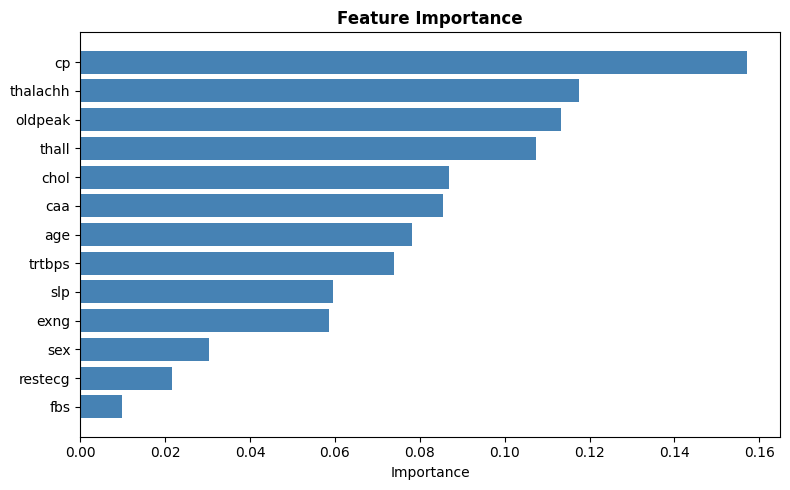

In [438]:
# Feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model_1.feature_importances_}
                                  ).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.title('Feature Importance', fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

---
## 6. Support Vector Machine

In [439]:
# Config 1: RBF kernel
svm_model_1 = SVC(kernel='rbf', probability=True, random_state=42)
svm_model_1.fit(X_train_scaled, y_train)
svm_pred_1 = svm_model_1.predict(X_test_scaled)
svm_accuracy_1 = accuracy_score(y_test, svm_pred_1)

print(f"Config 1 - RBF: {svm_accuracy_1*100:.2f}%")
print(classification_report(y_test, svm_pred_1))

Config 1 - RBF: 81.97%
              precision    recall  f1-score   support

           0       0.90      0.68      0.78        28
           1       0.78      0.94      0.85        33

    accuracy                           0.82        61
   macro avg       0.84      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



In [440]:
# Config 2: Linear kernel
svm_model_2 = SVC(kernel='linear', probability=True, random_state=42)
svm_model_2.fit(X_train_scaled, y_train)
svm_pred_2 = svm_model_2.predict(X_test_scaled)
svm_accuracy_2 = accuracy_score(y_test, svm_pred_2)

print(f"Config 2 - Linear: {svm_accuracy_2*100:.2f}%")
print(classification_report(y_test, svm_pred_2))

Config 2 - Linear: 78.69%
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61



In [441]:
# Config 3: RBF tuned
svm_model_3 = SVC(kernel='rbf', C=10, gamma=0.1, probability=True, random_state=42)
svm_model_3.fit(X_train_scaled, y_train)
svm_pred_3 = svm_model_3.predict(X_test_scaled)
svm_accuracy_3 = accuracy_score(y_test, svm_pred_3)

print(f"Config 3 - RBF tuned: {svm_accuracy_3*100:.2f}%")
print(classification_report(y_test, svm_pred_3))

Config 3 - RBF tuned: 75.41%
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        28
           1       0.76      0.79      0.78        33

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61



---
## 7. Neural Network

In [442]:
# Config 1: Simple (64-32)
nn_model_1 = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = nn_model_1.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_pred_1 = (nn_model_1.predict(X_test_scaled, verbose=0) > 0.5).astype(int).flatten()
nn_accuracy_1 = accuracy_score(y_test, nn_pred_1)

print(f"Config 1 - 64-32: {nn_accuracy_1*100:.2f}%")
print(classification_report(y_test, nn_pred_1))

Config 1 - 64-32: 77.05%
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



In [443]:
# Config 2: With Dropout (128-64-32)
nn_model_2 = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model_2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_2 = nn_model_2.fit(X_train_scaled, y_train, epochs=150, batch_size=16,
                           validation_split=0.2, callbacks=[early_stop], verbose=0)

nn_pred_2 = (nn_model_2.predict(X_test_scaled, verbose=0) > 0.5).astype(int).flatten()
nn_accuracy_2 = accuracy_score(y_test, nn_pred_2)

print(f"Config 2 - with Dropout: {nn_accuracy_2*100:.2f}%")
print(classification_report(y_test, nn_pred_2))

Config 2 - with Dropout: 77.05%
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        28
           1       0.73      0.91      0.81        33

    accuracy                           0.77        61
   macro avg       0.79      0.76      0.76        61
weighted avg       0.79      0.77      0.76        61



In [444]:
# Config 3: Wider (256-128-64)
nn_model_3 = Sequential([
    Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history_3 = nn_model_3.fit(X_train_scaled, y_train, epochs=200, batch_size=8, validation_split=0.2,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)], verbose=0)

nn_pred_3 = (nn_model_3.predict(X_test_scaled, verbose=0) > 0.5).astype(int).flatten()
nn_accuracy_3 = accuracy_score(y_test, nn_pred_3)

print(f"Config 3 - wider: {nn_accuracy_3*100:.2f}%")
print(classification_report(y_test, nn_pred_3))

Config 3 - wider: 80.33%
              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



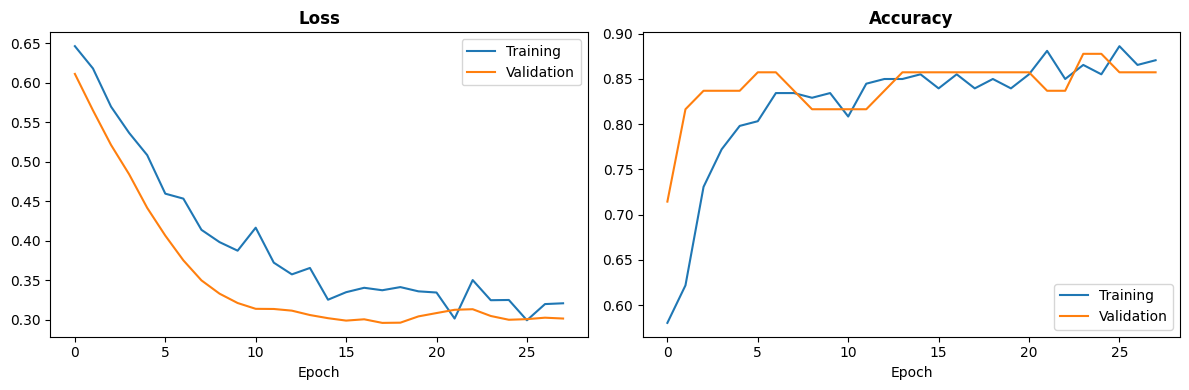

In [445]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_2.history['loss'], label='Training')
axes[0].plot(history_2.history['val_loss'], label='Validation')
axes[0].set_title('Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history_2.history['accuracy'], label='Training')
axes[1].plot(history_2.history['val_accuracy'], label='Validation')
axes[1].set_title('Accuracy', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 8. Model Comparison

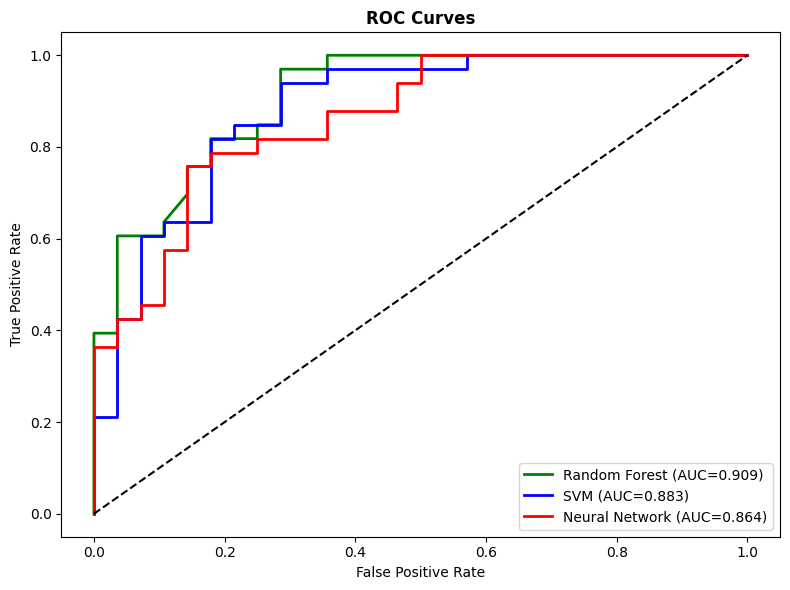

In [446]:
# ROC Curves
plt.figure(figsize=(8, 6))

for name, proba, color in [('Random Forest', rf_model_1.predict_proba(X_test_scaled)[:,1], 'green'),
                           ('SVM', svm_model_1.predict_proba(X_test_scaled)[:,1], 'blue'),
                           ('Neural Network', nn_model_1.predict(X_test_scaled, verbose=0).flatten(), 'red')]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

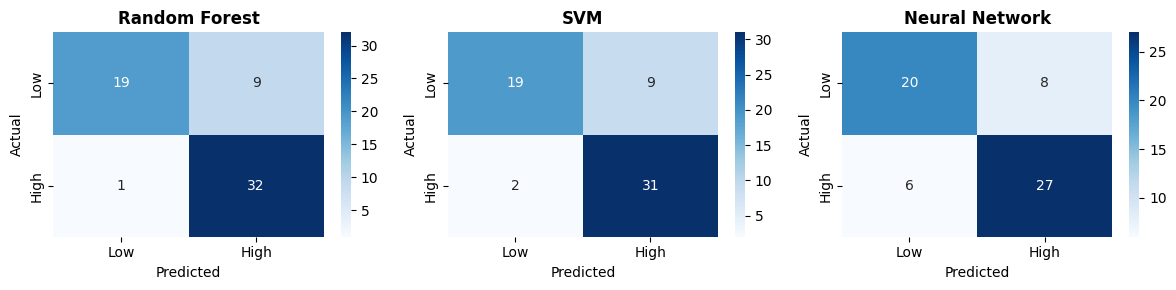

In [447]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, (name, pred) in zip(axes, [('Random Forest', rf_pred_1), ('SVM', svm_pred_1), ('Neural Network', nn_pred_1)]):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    ax.set_title(name, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [448]:
# Results summary
results = pd.DataFrame({
    'Model': ['RF Config 1', 'RF Config 2', 'RF Config 3',
              'SVM Config 1', 'SVM Config 2', 'SVM Config 3',
              'NN Config 1', 'NN Config 2', 'NN Config 3'],
    'Accuracy': [rf_accuracy_1, rf_accuracy_2, rf_accuracy_3,
                 svm_accuracy_1, svm_accuracy_2, svm_accuracy_3,
                 nn_accuracy_1, nn_accuracy_2, nn_accuracy_3]
})
results['%'] = (results['Accuracy'] * 100).round(2)
print(results.sort_values('Accuracy', ascending=False).to_string(index=False))

       Model  Accuracy     %
 RF Config 3  0.852459 85.25
 RF Config 1  0.836066 83.61
 RF Config 2  0.819672 81.97
SVM Config 1  0.819672 81.97
 NN Config 3  0.803279 80.33
SVM Config 2  0.786885 78.69
 NN Config 1  0.770492 77.05
 NN Config 2  0.770492 77.05
SVM Config 3  0.754098 75.41


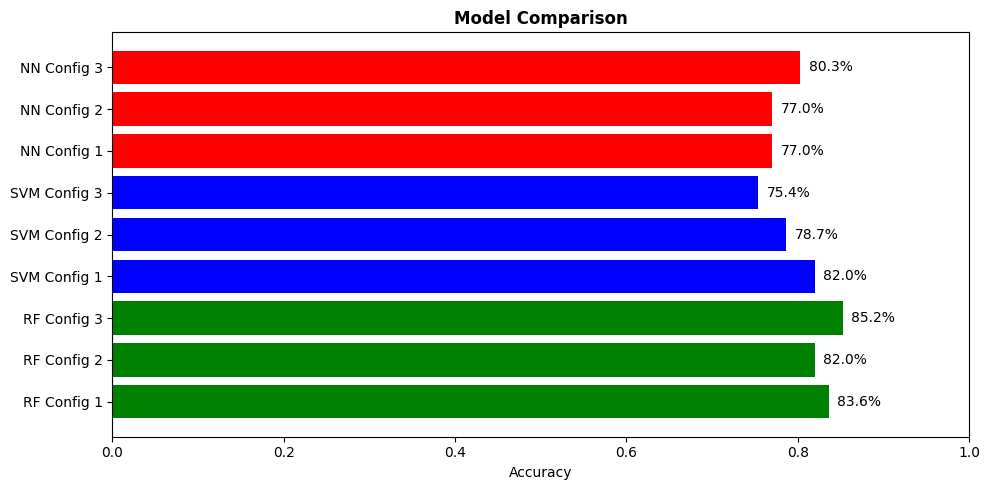

In [449]:
# Accuracy comparison
plt.figure(figsize=(10, 5))
colors = ['green']*3 + ['blue']*3 + ['red']*3
plt.barh(results['Model'], results['Accuracy'], color=colors)
for i, acc in enumerate(results['Accuracy']):
    plt.text(acc + 0.01, i, f'{acc*100:.1f}%', va='center')
plt.xlabel('Accuracy')
plt.title('Model Comparison', fontweight='bold')
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

---
## 9. Conclusion

This notebook implemented:
- **Random Forest** (3 configurations)
- **SVM** (3 configurations)
- **Neural Network** (3 configurations)

**Key findings:**
- Random Forest with sample constraints achieved the highest accuracy
- Feature importance identified cp, thalachh, and caa as most predictive
- Dropout regularization helped prevent overfitting in neural networks